<img src="http://bigdataexperience.org/BX/wp-content/uploads/2016/05/BX-FULL.png" width="200" height="200" alt="Big Data Experience Center, King Mongkut's University of Technology Thonburi">

# <center>Data Sciences</center>
# <center>Textual Data</center>
---

# <center>Tussanakorn Rattanaburee 62070505205</center>

## Import Library

In [1]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import regex as re
import nltk

In [2]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h3>{title}</h3>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

## Loading dataset

In [3]:
df = pd.read_csv('un-general-debates-blueprint.csv.gz')

In [4]:
df.sample(3)

,session,year,country,country_name,speaker,position,text
5327,59,2004,NER,Niger,Mrs. Aïchatou MINDAOUDOU,Minister for Foreign Affairs,"Allow me at the outset, Mr. President, to join..."
4061,52,1997,SDN,Sudan,Ali Osman Mohamed Taha,Minister for Foreign Affairs,﻿At\nthe outset I would like to express my con...
7312,69,2014,ZMB,Zambia,Harry Kalaba,Minister for Foreign Affairs,I extend our sincere \ncongratulations to Mr. ...


## DataFrame summary statistics

In [5]:
df['length'] = df['text'].str.len()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       7507 non-null   int64 
 1   year          7507 non-null   int64 
 2   country       7507 non-null   object
 3   country_name  7507 non-null   object
 4   speaker       7480 non-null   object
 5   position      4502 non-null   object
 6   text          7507 non-null   object
 7   length        7507 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 469.3+ KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,7507.0,49.610763,12.892155,25.0,39.0,51.0,61.0,70.0
year,7507.0,1994.610763,12.892155,1970.0,1984.0,1996.0,2006.0,2015.0
length,7507.0,17967.281604,7860.038463,2362.0,12077.0,16424.0,22479.5,72041.0


In [8]:
df[['country','speaker']].describe(include='O').T

,count,unique,top,freq
country,7507,199,VEN,46
speaker,7480,5428,Seyoum Mesfin,12


## Checking for missing data

In [9]:
#Checking
df.isna().sum()

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
text               0
length             0
dtype: int64

In [10]:
#Fixing
df['speaker'].fillna('unknown',inplace=True)

In [11]:
df.isna().sum()

session            0
year               0
country            0
country_name       0
speaker            0
position        3005
text               0
length             0
dtype: int64

## Define Functions

In [12]:
# Function Tokenization
def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [13]:
# Function Stopword Removal
stopwords = set(nltk.corpus.stopwords.words('english'))
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [14]:
## Function N-gram
def ngrams(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

In [15]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [16]:
## Function Count Words
def count_words(df, column='bigrams', preprocess=None, min_freq = 2):
    
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    
    # create counter and run through all data
    counter = Counter()
    df[column].map(update)
    
    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq > @min_freq')
    freq_df.index.name = 'bigrams'
    
    return freq_df.sort_values('freq', ascending=False)

In [17]:
## Function WordCloud
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Set2", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

In [18]:
## Function Count Keywords
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [19]:
## Function Count Keywords
def count_keywords_by(df, by, keywords,column):
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by]
    
    return freq_df.groupby(by).sum().sort_values(by)

In [20]:
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)

---

# <center>Lab Textual Data</center>

### 1. Find the top 10 word bigram from UN General Debates of years 1970 –1990 and compare with those of years 1990 –the latest (remove stopwords first)

In [21]:
pipeline = [str.lower, tokenize, remove_stop, ngrams]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [22]:
df['bigrams'] = df['text'].apply(prepare, pipeline=pipeline)

In [23]:
df['num_bigrams'] = df['bigrams'].map(len)

In [24]:
df.head()

,session,year,country,country_name,speaker,position,text,length,tokens,bigrams,num_bigrams
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...,51419,"[may, first, convey, president, congratulation...","[may first, first convey, convey president, pr...",4091
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...,29286,"[fortunate, coincidence, precisely, time, unit...","[fortunate coincidence, coincidence precisely,...",2340
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...,31839,"[pleasure, extend, mr, president, warmest, con...","[pleasure extend, extend mr, mr president, pre...",2574
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...,26616,"[may, begin, expressing, ambassador, hambro, b...","[may begin, begin expressing, expressing ambas...",2165
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ...",25911,"[doubt, us, coming, rostrum, wonders, usefulne...","[doubt us, us coming, coming rostrum, rostrum ...",2063


In [25]:
bigram_1 = df.query('1970 <= year <= 1990')
bigram_2 = df.query('year >= 1990')

In [26]:
df_bigram_1 = count_words(bigram_1, column='bigrams')
df_bigram_2 = count_words(bigram_2, column='bigrams')
display_side_by_side(df_bigram_1.head(10),df_bigram_2.head(10),
                     titles=['10 word of years 1970–1990','10 word of years 1990- the latest'])

,freq
bigrams,
united nations,43846
general assembly,13915
developing countries,11991
international community,11506
south africa,9300
united states,7718
middle east,7608
security council,7500
peace security,6755


---

### 2. Create a bigram word cloud of the UN General Debates dataset of years 1970 –1990 and 1990 to the latest (remove stopwords first)

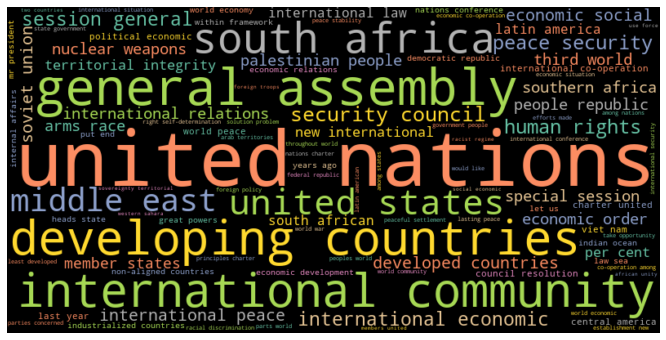

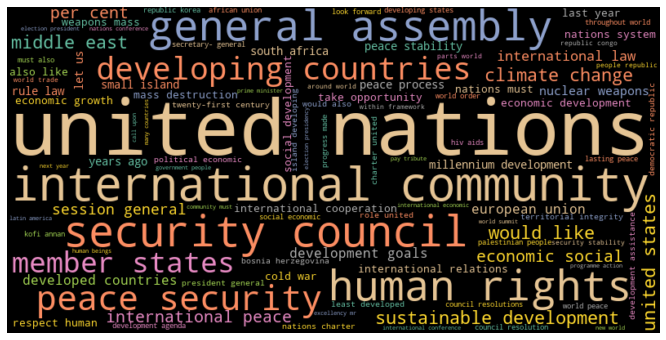

In [27]:
plt.figure(figsize=(16,6))
wordcloud(df_bigram_1['freq'], max_words=100)

plt.figure(figsize=(16,6))
wordcloud(df_bigram_2['freq'], max_words=100)

---

### 3. Create a trend graph showing the bigram and word trend of “climate change”, “global warming”, “wars” and 3 others of your choices

In [28]:
keywords = ['climate change','global warming','human rights','peace security','economic social']
keywords1 = ['wars']

In [29]:
freq_df = count_keywords_by(df, by='year', keywords=keywords, column='bigrams')
freq_df1 = count_keywords_by(df, by='year', keywords=keywords1, column='tokens')

In [30]:
freq_result = pd.concat([freq_df, freq_df1], axis=1)

<AxesSubplot:xlabel='year'>

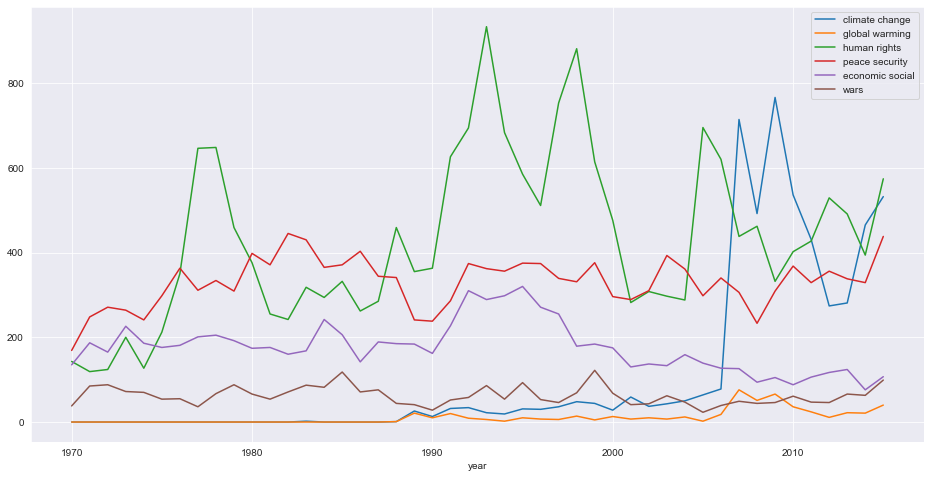

In [31]:
sns.set_style("darkgrid")
freq_result.plot(kind='line', figsize=(16,8))

---